# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

-   анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
-   контролировать добросовестность кассиров при продаже алкоголя.

Построим модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Необходимо добиться значения MAE на тестовой выборке не больше 8.

В [статье о датасете,](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf) с которым мы работаем, значение MAE равно 5.4.

Данные взяты с сайта _[ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/)

## Исследовательский анализ данных

In [1]:
%%capture
!pip install scikit-image

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import os
import re
from skimage.io import imread

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
np.random.seed(42)

In [3]:
os.listdir('/datasets/faces')

['labels.csv', 'final_files']

Список отсортированных файлов в директории с отбором первых пяти:

In [4]:
path = '/datasets/faces/final_files/'
files = os.listdir(path)
sorted_files = sorted(files)

sorted_files[:5]

['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg']

Чтение и вывод начала файла с метками (labels) 

In [5]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')
df_labels.head()

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

In [6]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Гистограмма распределения возраста в выборке

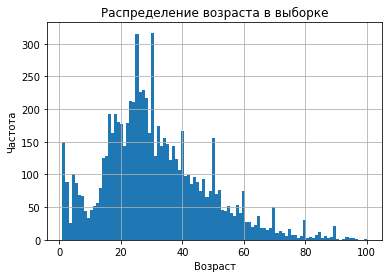

In [7]:
df_labels['real_age'].hist(bins=100)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста в выборке')
plt.show()

Гистограмма распределения возраста в выборке показывает, что в нашем наборе данных наиболее часто встречаются люди в возрасте от 20 до 35 лет. На гистограмме наблюдается пик около возраста 30 лет, а также второй пик около возраста 25 лет. Самый младший возраст в выборке - 1 год, а самый старший - 100 лет. В целом, гистограмма имеет форму, схожую с колоколом (нормальное распределение), но имеет несколько выраженных пиков, что может указывать на отсутствие данных по возрасту у части выборки и заполнении этих строк округленными значениями.

### Анализ набора фотографий

Вариант 1

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
%%time
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.
CPU times: user 55.8 ms, sys: 11.8 ms, total: 67.6 ms
Wall time: 66.6 ms


In [11]:
features, target = next(train_gen_flow)

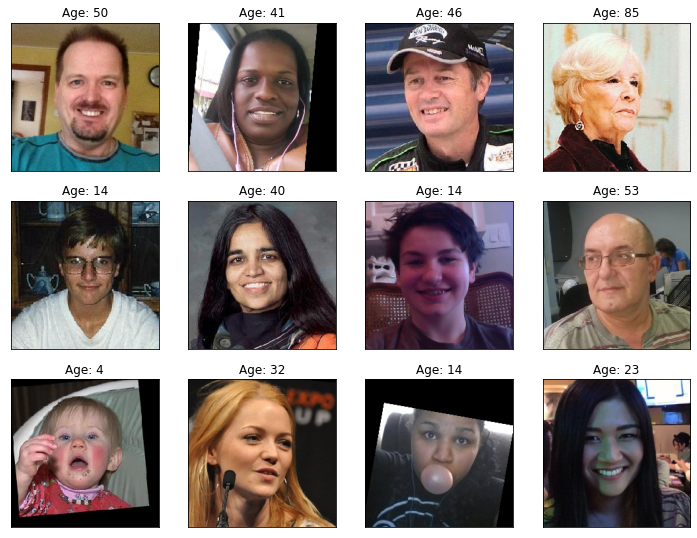

In [12]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Вариант 2

In [13]:
images = [(whale_img, whale_label) for (whale_img, whale_label) \
          in zip(df_labels.file_name[:5], df_labels.real_age[:5])]

images

[('000000.jpg', 4),
 ('000001.jpg', 18),
 ('000002.jpg', 80),
 ('000003.jpg', 50),
 ('000004.jpg', 17)]

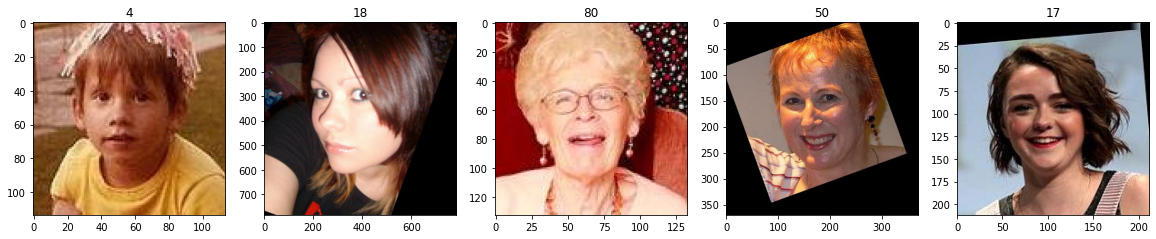

In [14]:
fig, m_axs = plt.subplots(1, len(images), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(imread(os.path.join(path,images[ii][0])))
    c_ax.set_title(images[ii][1])

### Выводы:

    1.Состав выборки: Датасет состоит из 7591 цветной фотографии разного размера.

    2.Распределение возраста: Распределение возраста напоминает нормальное распределение с некоторым смещением в сторону пожилых возрастов и выбросами в возрастном диапазоне от 0 до 10 лет. Это может повлиять на качество обучения, поскольку для очень пожилых людей (чем старше, тем меньше данных) и детей около 10-15 лет доступно меньше данных.

    3.Выравнивание и качество изображений: Исходя из предоставленных образцов фотографий, изображения повернуты и смещены таким образом, чтобы лица находились в вертикальном положении и располагались в центре изображений. Качество изображений оценивается как приемлемое, присутствует незначительный уровень шума.

    4.Разнообразие объектов: Датасет обладает достаточным разнообразием объектов.
    
    5.Размеры изображений: Размеры изображений могут варьироваться. Перед обучением модели размеры изображений будут стандартизированы.

## Обучение модели

Код в этом разделе и вычисления производились на сервере с графической картой (GPU) Yandex Compute Cloud

### Функция парсинга результатов

In [15]:
def parse_data(data):
    data_dict = {'epoch': [], 'time': [], 'loss': [], 'mae': [], 'val_loss': [], 'val_mae': []}
    lines = data.split('\n')
    pairs = [lines[i] + lines[i+1] for i in range(0, len(lines), 2)]
    for line in pairs:
        match = re.search(r'Epoch (\d+)/\d+/\d+ - (\d+)s - loss: ([\d.]+) - mae: ([\d.]+) - val_loss: ([\d.]+) - val_mae: ([\d.]+)', line)
        if match:
            epoch = int(match.group(1))
            time = int(match.group(2))
            loss = float(match.group(3))
            mae = float(match.group(4))
            val_loss = float(match.group(5))
            val_mae = float(match.group(6))
            data_dict['epoch'].append(epoch)
            data_dict['time'].append(time)
            data_dict['loss'].append(loss)
            data_dict['mae'].append(mae)
            data_dict['val_loss'].append(val_loss)
            data_dict['val_mae'].append(val_mae)
    return pd.DataFrame(data_dict)

### Код обучения базовой модели

```python
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.2,
                                       rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
                        dataframe=pd.read_csv(path + '/labels.csv'),
                        directory= path + '/final_files',
                        x_col='file_name',
                        y_col='real_age',
                        target_size=(224, 224),
                        batch_size=32,
                        class_mode='raw',
                        subset='training',
                        seed=12345)
    return train_datagen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.2,
                                       rescale=1./255)
    val_datagen_flow = test_datagen.flow_from_dataframe(
                        dataframe=pd.read_csv(path + '/labels.csv'),
                        directory= path + '/final_files',
                        x_col='file_name',
                        y_col='real_age',
                        target_size=(224, 224),
                        batch_size=32,
                        class_mode='raw',
                        subset='validation',
                        seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, 
                train_datagen_flow, 
                val_datagen_flow, 
                batch_size=None, 
                epochs=20,
                steps_per_epoch=None, 
                validation_steps=None):
    
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

#### Результат вывода на экран

In [16]:
results_base = """Train for 190 steps, validate for 48 steps
2023-05-17 07:19:31
Epoch 1/20
190/190 - 47s - loss: 222.7054 - mae: 10.5753 - val_loss: 730.7192 - val_mae: 21.9643
Epoch 2/20
190/190 - 38s - loss: 62.0470 - mae: 5.9360 - val_loss: 598.5372 - val_mae: 19.3101
Epoch 3/20
190/190 - 38s - loss: 31.6257 - mae: 4.3524 - val_loss: 318.9237 - val_mae: 13.3122
Epoch 4/20
190/190 - 38s - loss: 20.6489 - mae: 3.5147 - val_loss: 110.3729 - val_mae: 7.8614
Epoch 5/20
190/190 - 39s - loss: 14.6463 - mae: 2.9881 - val_loss: 74.1054 - val_mae: 6.4780
Epoch 6/20
190/190 - 39s - loss: 11.9905 - mae: 2.7068 - val_loss: 71.2676 - val_mae: 6.5870
Epoch 7/20
190/190 - 39s - loss: 10.3853 - mae: 2.4892 - val_loss: 86.9632 - val_mae: 6.9747
Epoch 8/20
190/190 - 40s - loss: 9.2580 - mae: 2.2950 - val_loss: 65.4172 - val_mae: 6.0497
Epoch 9/20
190/190 - 39s - loss: 8.6133 - mae: 2.2164 - val_loss: 69.8669 - val_mae: 6.4869
Epoch 10/20
190/190 - 39s - loss: 8.0062 - mae: 2.1272 - val_loss: 64.6468 - val_mae: 6.1842
Epoch 11/20
190/190 - 39s - loss: 6.9642 - mae: 1.9729 - val_loss: 68.1272 - val_mae: 6.2864
Epoch 12/20
190/190 - 38s - loss: 5.6419 - mae: 1.7502 - val_loss: 60.5808 - val_mae: 5.8948
Epoch 13/20
190/190 - 38s - loss: 5.0169 - mae: 1.6655 - val_loss: 62.8239 - val_mae: 5.9767
Epoch 14/20
190/190 - 38s - loss: 4.2354 - mae: 1.5408 - val_loss: 62.0084 - val_mae: 6.0468
Epoch 15/20
190/190 - 39s - loss: 4.1095 - mae: 1.5372 - val_loss: 61.5773 - val_mae: 5.9161
Epoch 16/20
190/190 - 39s - loss: 4.0230 - mae: 1.5073 - val_loss: 63.6752 - val_mae: 6.0685
Epoch 17/20
190/190 - 38s - loss: 4.1058 - mae: 1.5199 - val_loss: 61.6987 - val_mae: 5.9557
Epoch 18/20
190/190 - 38s - loss: 4.4268 - mae: 1.5890 - val_loss: 65.9867 - val_mae: 6.0956
Epoch 19/20
190/190 - 40s - loss: 5.3368 - mae: 1.7401 - val_loss: 61.2774 - val_mae: 5.9093
Epoch 20/20
190/190 - 39s - loss: 5.8263 - mae: 1.8521 - val_loss: 63.1141 - val_mae: 5.8420"""

In [17]:
df_results_base = parse_data(results_base)
df_results_base.sort_values('val_mae').head(3)

epoch  time    loss     mae  val_loss  val_mae
19     20    39  5.8263  1.8521   63.1141   5.8420
11     12    38  5.6419  1.7502   60.5808   5.8948
18     19    40  5.3368  1.7401   61.2774   5.9093

### Добавление к модели аугментации

```python
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd


def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.2,
                                       rescale=1./255,
                                horizontal_flip=True,
                                width_shift_range=0.2,
                                height_shift_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(
                        dataframe=pd.read_csv(path + '/labels.csv'),
                        directory= path + '/final_files',
                        x_col='file_name',
                        y_col='real_age',
                        target_size=(224, 224),
                        batch_size=32,
                        class_mode='raw',
                        subset='training',
                        seed=12345)
    return train_datagen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.2,
                                       rescale=1./255)
    val_datagen_flow = test_datagen.flow_from_dataframe(
                        dataframe=pd.read_csv(path + '/labels.csv'),
                        directory= path + '/final_files',
                        x_col='file_name',
                        y_col='real_age',
                        target_size=(224, 224),
                        batch_size=32,
                        class_mode='raw',
                        subset='validation',
                        seed=12345)
    return val_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model


def train_model(model, 
                train_datagen_flow, 
                val_datagen_flow, 
                batch_size=None, 
                epochs=20,
                steps_per_epoch=None, 
                validation_steps=None):
    
    np.random.seed(42)
    tf.random.set_seed(42)
    
    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

#### Результат вывода на экран

In [18]:
results_aug = """Train for 190 steps, validate for 48 steps
2023-05-17 08:15:09
Epoch 1/20
190/190 - 120s - loss: 264.1221 - mae: 11.6316 - val_loss: 1073.0447 - val_mae: 28.0377
Epoch 2/20
190/190 - 93s - loss: 93.8293 - mae: 7.3060 - val_loss: 463.1994 - val_mae: 16.2644
Epoch 3/20
190/190 - 93s - loss: 74.0278 - mae: 6.5301 - val_loss: 210.0130 - val_mae: 10.6344
Epoch 4/20
190/190 - 92s - loss: 58.2753 - mae: 5.8093 - val_loss: 157.2743 - val_mae: 9.5147
Epoch 5/20
190/190 - 93s - loss: 50.3128 - mae: 5.4369 - val_loss: 73.7537 - val_mae: 6.4454
Epoch 6/20
190/190 - 92s - loss: 43.1010 - mae: 5.0080 - val_loss: 73.6222 - val_mae: 6.4960
Epoch 7/20
190/190 - 93s - loss: 38.9964 - mae: 4.7964 - val_loss: 70.2758 - val_mae: 6.4539
Epoch 8/20
190/190 - 94s - loss: 33.6588 - mae: 4.5123 - val_loss: 86.1843 - val_mae: 6.7517
Epoch 9/20
190/190 - 92s - loss: 29.7085 - mae: 4.1809 - val_loss: 85.5993 - val_mae: 6.7969
Epoch 10/20
190/190 - 92s - loss: 26.4526 - mae: 3.9688 - val_loss: 73.0010 - val_mae: 6.1724
Epoch 11/20
190/190 - 92s - loss: 24.7673 - mae: 3.8460 - val_loss: 81.4239 - val_mae: 6.5970
Epoch 12/20
190/190 - 93s - loss: 22.9128 - mae: 3.6725 - val_loss: 76.5287 - val_mae: 6.3677
Epoch 13/20
190/190 - 93s - loss: 20.8441 - mae: 3.5142 - val_loss: 62.0882 - val_mae: 5.7906
Epoch 14/20
190/190 - 92s - loss: 20.8916 - mae: 3.5148 - val_loss: 86.1657 - val_mae: 7.0181
Epoch 15/20
190/190 - 92s - loss: 17.4287 - mae: 3.2212 - val_loss: 62.6942 - val_mae: 5.9090
Epoch 16/20
190/190 - 94s - loss: 15.1835 - mae: 2.9936 - val_loss: 64.5443 - val_mae: 5.9091
Epoch 17/20
190/190 - 93s - loss: 13.8133 - mae: 2.8500 - val_loss: 69.3686 - val_mae: 5.9374
Epoch 18/20
190/190 - 102s - loss: 15.1616 - mae: 2.9733 - val_loss: 63.9062 - val_mae: 5.8501
Epoch 19/20
190/190 - 102s - loss: 13.9473 - mae: 2.8385 - val_loss: 62.8388 - val_mae: 5.6917
Epoch 20/20
None"""

In [19]:
df_results_aug = parse_data(results_aug)
df_results_aug.sort_values('val_mae').head(3)

epoch  time     loss     mae  val_loss  val_mae
18     19   102  13.9473  2.8385   62.8388   5.6917
12     13    93  20.8441  3.5142   62.0882   5.7906
17     18   102  15.1616  2.9733   63.9062   5.8501

тренажер завис на 20 эпохе

In [20]:
df_results_aug = df_results_aug.append([{}], ignore_index=True)

In [21]:
df_results_aug.tail(3)

epoch   time     loss     mae  val_loss  val_mae
17   18.0  102.0  15.1616  2.9733   63.9062   5.8501
18   19.0  102.0  13.9473  2.8385   62.8388   5.6917
19    NaN    NaN      NaN     NaN       NaN      NaN

### Модель с Dropout 0.25

```python
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='relu'))
```

In [22]:
results_drop25 = """Train for 190 steps, validate for 48 steps
2023-05-16 20:37:51
Epoch 1/20
190/190 - 111s - loss: 253.1687 - mae: 11.4179 - val_loss: 920.9088 - val_mae: 25.3896
Epoch 2/20
190/190 - 102s - loss: 90.8234 - mae: 7.2295 - val_loss: 825.1577 - val_mae: 23.7021
Epoch 3/20
190/190 - 101s - loss: 73.8927 - mae: 6.5033 - val_loss: 471.3922 - val_mae: 16.6750
Epoch 4/20
190/190 - 103s - loss: 59.7556 - mae: 5.8807 - val_loss: 116.3844 - val_mae: 8.1172
Epoch 5/20
190/190 - 101s - loss: 49.3442 - mae: 5.3306 - val_loss: 81.4300 - val_mae: 6.8044
Epoch 6/20
190/190 - 101s - loss: 42.6860 - mae: 5.0096 - val_loss: 73.6604 - val_mae: 6.5437
Epoch 7/20
190/190 - 97s - loss: 37.5878 - mae: 4.7263 - val_loss: 65.0339 - val_mae: 5.9235
Epoch 8/20
190/190 - 92s - loss: 34.2355 - mae: 4.5243 - val_loss: 64.3069 - val_mae: 5.8097
Epoch 9/20
190/190 - 94s - loss: 30.6708 - mae: 4.2641 - val_loss: 94.0212 - val_mae: 7.0858
Epoch 10/20
190/190 - 95s - loss: 29.3905 - mae: 4.1679 - val_loss: 71.9341 - val_mae: 6.4253
Epoch 11/20
190/190 - 98s - loss: 26.2683 - mae: 3.9404 - val_loss: 69.3946 - val_mae: 6.0752
Epoch 12/20
190/190 - 100s - loss: 25.5807 - mae: 3.8577 - val_loss: 84.1000 - val_mae: 6.7582
Epoch 13/20
190/190 - 97s - loss: 21.6211 - mae: 3.5730 - val_loss: 66.4965 - val_mae: 5.9194
Epoch 14/20
190/190 - 96s - loss: 19.5282 - mae: 3.3848 - val_loss: 59.2168 - val_mae: 5.6555
Epoch 15/20
190/190 - 103s - loss: 17.9797 - mae: 3.2589 - val_loss: 73.6642 - val_mae: 6.2562
Epoch 16/20
190/190 - 104s - loss: 16.5665 - mae: 3.1065 - val_loss: 61.1920 - val_mae: 5.7368
Epoch 17/20
190/190 - 104s - loss: 16.4737 - mae: 3.1407 - val_loss: 63.3354 - val_mae: 5.7700
Epoch 18/20
190/190 - 103s - loss: 14.2262 - mae: 2.8897 - val_loss: 63.4954 - val_mae: 5.9344
Epoch 19/20
190/190 - 104s - loss: 13.6034 - mae: 2.8302 - val_loss: 58.6046 - val_mae: 5.5799
Epoch 20/20
190/190 - 103s - loss: 12.6221 - mae: 2.7277 - val_loss: 69.0698 - val_mae: 5.9311"""

In [23]:
df_results_drop25 = parse_data(results_drop25)
df_results_drop25.sort_values('val_mae').head(3)

epoch  time     loss     mae  val_loss  val_mae
18     19   104  13.6034  2.8302   58.6046   5.5799
13     14    96  19.5282  3.3848   59.2168   5.6555
15     16   104  16.5665  3.1065   61.1920   5.7368

### Модель с Dropout 0.25 + aug.

In [24]:
results_drop25_aug = """Train for 190 steps, validate for 48 steps
2023-05-17 13:12:28
Epoch 1/20
190/190 - 187s - loss: 253.7163 - mae: 11.3020 - val_loss: 404.0206 - val_mae: 14.9917
Epoch 2/20
190/190 - 104s - loss: 89.8799 - mae: 7.1963 - val_loss: 511.0847 - val_mae: 17.4158
Epoch 3/20
190/190 - 105s - loss: 72.2128 - mae: 6.4990 - val_loss: 343.4312 - val_mae: 13.6283
Epoch 4/20
190/190 - 106s - loss: 61.6131 - mae: 5.9421 - val_loss: 136.2657 - val_mae: 8.9770
Epoch 5/20
190/190 - 107s - loss: 50.3158 - mae: 5.4762 - val_loss: 77.8937 - val_mae: 6.6115
Epoch 6/20
190/190 - 105s - loss: 45.0135 - mae: 5.1668 - val_loss: 72.0793 - val_mae: 6.2670
Epoch 7/20
190/190 - 98s - loss: 39.4255 - mae: 4.7842 - val_loss: 76.4956 - val_mae: 6.6874
Epoch 8/20
190/190 - 101s - loss: 34.2819 - mae: 4.5195 - val_loss: 122.5233 - val_mae: 8.3304
Epoch 9/20
190/190 - 101s - loss: 32.1560 - mae: 4.3670 - val_loss: 66.9389 - val_mae: 6.0289
Epoch 10/20
190/190 - 101s - loss: 28.7040 - mae: 4.1404 - val_loss: 77.5818 - val_mae: 6.3762
Epoch 11/20
190/190 - 98s - loss: 26.2365 - mae: 3.9519 - val_loss: 73.8496 - val_mae: 6.2414
Epoch 12/20
190/190 - 95s - loss: 22.8557 - mae: 3.6693 - val_loss: 65.7768 - val_mae: 5.9138
Epoch 13/20
190/190 - 96s - loss: 20.6350 - mae: 3.4991 - val_loss: 62.7526 - val_mae: 5.8884
Epoch 14/20
190/190 - 96s - loss: 18.9021 - mae: 3.3532 - val_loss: 68.7102 - val_mae: 6.0367
Epoch 15/20
190/190 - 96s - loss: 17.8475 - mae: 3.2935 - val_loss: 69.2214 - val_mae: 6.1856
Epoch 16/20
190/190 - 96s - loss: 16.0841 - mae: 3.0907 - val_loss: 63.4209 - val_mae: 5.7567
Epoch 17/20
190/190 - 96s - loss: 14.7196 - mae: 2.9602 - val_loss: 72.8065 - val_mae: 6.2923
Epoch 18/20
190/190 - 95s - loss: 14.8258 - mae: 2.9640 - val_loss: 75.6425 - val_mae: 6.2668
Epoch 19/20
190/190 - 96s - loss: 14.1336 - mae: 2.8760 - val_loss: 62.5151 - val_mae: 5.7765
Epoch 20/20
190/190 - 95s - loss: 13.4561 - mae: 2.8169 - val_loss: 63.5569 - val_mae: 5.7823"""

In [25]:
df_results_drop25_aug = parse_data(results_drop25_aug)
df_results_drop25_aug.sort_values('val_mae').head(3)

epoch  time     loss     mae  val_loss  val_mae
15     16    96  16.0841  3.0907   63.4209   5.7567
18     19    96  14.1336  2.8760   62.5151   5.7765
19     20    95  13.4561  2.8169   63.5569   5.7823

### Модель с доп. слоем Dense(256)+aug.

добавлен слой model.add(Dense(256, activation='relu'))
```python
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))
```

In [26]:
results_dense = """Train for 190 steps, validate for 48 steps
2023-05-16 16:49:45
Epoch 1/20
190/190 - 122s - loss: 191.5792 - mae: 10.1436 - val_loss: 412.8016 - val_mae: 15.2172
Epoch 2/20
190/190 - 97s - loss: 88.4716 - mae: 7.1133 - val_loss: 438.7651 - val_mae: 15.6784
Epoch 3/20
190/190 - 93s - loss: 63.5782 - mae: 6.0854 - val_loss: 323.3089 - val_mae: 13.2232
Epoch 4/20
190/190 - 93s - loss: 52.3334 - mae: 5.5371 - val_loss: 120.3828 - val_mae: 8.4476
Epoch 5/20
190/190 - 99s - loss: 44.4996 - mae: 5.1219 - val_loss: 76.9128 - val_mae: 6.5753
Epoch 6/20
190/190 - 97s - loss: 36.2375 - mae: 4.6293 - val_loss: 89.3166 - val_mae: 7.2492
Epoch 7/20
190/190 - 98s - loss: 30.6126 - mae: 4.2795 - val_loss: 76.3189 - val_mae: 6.7114
Epoch 8/20
190/190 - 97s - loss: 26.0978 - mae: 3.9546 - val_loss: 79.6827 - val_mae: 6.4927
Epoch 9/20
190/190 - 105s - loss: 22.1843 - mae: 3.6007 - val_loss: 71.9570 - val_mae: 6.2613
Epoch 10/20
190/190 - 98s - loss: 20.2408 - mae: 3.4406 - val_loss: 71.1986 - val_mae: 6.1848
Epoch 11/20
190/190 - 96s - loss: 18.3209 - mae: 3.2882 - val_loss: 77.2583 - val_mae: 6.5240
Epoch 12/20
190/190 - 93s - loss: 19.5408 - mae: 3.3413 - val_loss: 67.1362 - val_mae: 5.9656
Epoch 13/20
190/190 - 92s - loss: 17.1176 - mae: 3.1513 - val_loss: 65.8912 - val_mae: 6.0506
Epoch 14/20
190/190 - 92s - loss: 16.5430 - mae: 3.0701 - val_loss: 78.3404 - val_mae: 6.2687
Epoch 15/20
190/190 - 92s - loss: 13.7707 - mae: 2.8546 - val_loss: 68.0079 - val_mae: 6.0107
Epoch 16/20
190/190 - 92s - loss: 12.9824 - mae: 2.7276 - val_loss: 68.4064 - val_mae: 6.2744
Epoch 17/20
190/190 - 92s - loss: 12.6331 - mae: 2.6762 - val_loss: 60.7690 - val_mae: 5.7063
Epoch 18/20
190/190 - 92s - loss: 10.9148 - mae: 2.5342 - val_loss: 64.4231 - val_mae: 6.0068
Epoch 19/20
190/190 - 92s - loss: 11.4146 - mae: 2.5870 - val_loss: 63.5654 - val_mae: 5.8985
Epoch 20/20
190/190 - 92s - loss: 12.3529 - mae: 2.6673 - val_loss: 73.3111 - val_mae: 6.2082"""

In [27]:
df_results_dense = parse_data(results_dense)
df_results_dense.sort_values('val_mae').head(3)

epoch  time     loss     mae  val_loss  val_mae
16     17    92  12.6331  2.6762   60.7690   5.7063
18     19    92  11.4146  2.5870   63.5654   5.8985
11     12    93  19.5408  3.3413   67.1362   5.9656

### Модель с Dense(256) + Dropout 0.2 + aug.

In [28]:
results_dropout_20 = """Train for 190 steps, validate for 48 steps
2023-05-16 08:27:13
Epoch 1/20
190/190 - 99s - loss: 214.9417 - mae: 10.5863 - val_loss: 499.2058 - val_mae: 17.1236
Epoch 2/20
190/190 - 92s - loss: 90.8456 - mae: 7.3015 - val_loss: 467.1117 - val_mae: 16.3784
Epoch 3/20
190/190 - 92s - loss: 68.3876 - mae: 6.3335 - val_loss: 261.0575 - val_mae: 11.8829
Epoch 4/20
190/190 - 92s - loss: 61.2505 - mae: 5.9683 - val_loss: 138.0718 - val_mae: 8.5273
Epoch 5/20
190/190 - 92s - loss: 50.3861 - mae: 5.4453 - val_loss: 76.6118 - val_mae: 6.4388
Epoch 6/20
190/190 - 92s - loss: 43.9526 - mae: 5.0893 - val_loss: 70.4319 - val_mae: 6.1135
Epoch 7/20
190/190 - 92s - loss: 36.3268 - mae: 4.6223 - val_loss: 84.8187 - val_mae: 6.7999
Epoch 8/20
190/190 - 92s - loss: 35.0834 - mae: 4.5115 - val_loss: 79.9545 - val_mae: 6.5009
Epoch 9/20
190/190 - 92s - loss: 30.3309 - mae: 4.2649 - val_loss: 75.8983 - val_mae: 6.5928
Epoch 10/20
190/190 - 92s - loss: 28.2470 - mae: 4.0298 - val_loss: 69.2817 - val_mae: 6.1854
Epoch 11/20
190/190 - 91s - loss: 26.0028 - mae: 3.8873 - val_loss: 69.3247 - val_mae: 6.0070
Epoch 12/20
190/190 - 92s - loss: 23.0012 - mae: 3.6625 - val_loss: 70.2387 - val_mae: 6.1513
Epoch 13/20
190/190 - 91s - loss: 22.6339 - mae: 3.5996 - val_loss: 75.1658 - val_mae: 6.5038
Epoch 14/20
190/190 - 92s - loss: 22.4521 - mae: 3.6096 - val_loss: 74.2232 - val_mae: 6.2332
Epoch 15/20
190/190 - 91s - loss: 20.5663 - mae: 3.4413 - val_loss: 77.5460 - val_mae: 6.4435
Epoch 16/20
190/190 - 92s - loss: 19.0199 - mae: 3.3439 - val_loss: 67.0387 - val_mae: 5.9648
Epoch 17/20
190/190 - 92s - loss: 18.1339 - mae: 3.2336 - val_loss: 63.3361 - val_mae: 5.7936
Epoch 18/20
190/190 - 91s - loss: 18.4136 - mae: 3.2341 - val_loss: 65.0755 - val_mae: 5.9267
Epoch 19/20
190/190 - 92s - loss: 17.2790 - mae: 3.1608 - val_loss: 68.2886 - val_mae: 6.0504
Epoch 20/20
190/190 - 92s - loss: 17.8353 - mae: 3.2112 - val_loss: 61.9189 - val_mae: 5.8990
48/48 - 8s - loss: 61.9189 - mae: 5.8990
Test MAE: 5.8990"""

In [31]:
df_results_drop20 = parse_data(results_dropout_20)
df_results_drop20.sort_values('val_mae').head(3)

epoch  time     loss     mae  val_loss  val_mae
16     17    92  18.1339  3.2336   63.3361   5.7936
19     20    92  17.8353  3.2112   61.9189   5.8990
17     18    91  18.4136  3.2341   65.0755   5.9267

## Анализ обученной модели

Построим графики и сводную таблицу

In [32]:
# Создание списков с данными
labels = ['base', 'aug.', 'Dropout 0.25', 'Dropout_0.25+aug', 'aug.+Dense(256)', 'aug.+Dense(256)+Drop 0.2']
datasets = [df_results_base, df_results_aug, df_results_drop25, df_results_drop25_aug, df_results_dense, df_results_drop20]
epoch = df_results_base['epoch']
# Создание интерактивного графика
fig = go.Figure()

for label, dataset in zip(labels, datasets):
    fig.add_trace(go.Scatter(x=epoch, y=dataset['val_mae'], name=f'Val., {label}'))
    fig.add_trace(go.Scatter(x=epoch, y=dataset['mae'], name=f'Train., {label}'))

fig.update_layout(
    title='Validation and Training MAE',
    xaxis_title='Epoch',
    yaxis_title='MAE',
    legend=dict(orientation='h', yanchor='bottom', y=0.75, xanchor='right', x=1),
    template='plotly_white'
)

# Отображение интерактивного графика
pio.show(fig)

In [33]:
import pandas as pd

datasets = {
    'base': df_results_base,
    'augmentation': df_results_aug,
    'Dropout_0.25': df_results_drop25,
    'Dropout_0.25+augmentation': df_results_drop25_aug,
    'augmentation+Dense(256)': df_results_dense,
    'Dropout_0.20+augmentation+Dense(256)': df_results_drop20
}

best_mae_rows = []
df_names = []
cumulative_times = []
for name, df in datasets.items():
    min_val_mae_row = df.loc[df['val_mae'].idxmin()].copy()
    best_mae_rows.append(min_val_mae_row)
    df_names.append(name)
    epoch = min_val_mae_row['epoch']
    cumulative_time = df.loc[df['epoch'] <= epoch, 'time'].sum()
    cumulative_times.append(cumulative_time)

summary_df = pd.concat(best_mae_rows, axis=1).T
summary_df['name_model'] = df_names
summary_df['Cumulative_Time'] = cumulative_times

summary_df = summary_df.sort_values(by='val_mae')
summary_df.reset_index(drop=True, inplace=True)
summary_df['val_mae_percent'] = ((summary_df['val_mae'] / summary_df['val_mae'].max()) * 100).round(2)
summary_df

epoch   time     loss     mae  val_loss  val_mae  \
0   19.0  104.0  13.6034  2.8302   58.6046   5.5799   
1   19.0  102.0  13.9473  2.8385   62.8388   5.6917   
2   17.0   92.0  12.6331  2.6762   60.7690   5.7063   
3   16.0   96.0  16.0841  3.0907   63.4209   5.7567   
4   17.0   92.0  18.1339  3.2336   63.3361   5.7936   
5   20.0   39.0   5.8263  1.8521   63.1141   5.8420   

                             name_model  Cumulative_Time  val_mae_percent  
0                          Dropout_0.25           1906.0            95.51  
1                          augmentation           1807.0            97.43  
2               augmentation+Dense(256)           1648.0            97.68  
3             Dropout_0.25+augmentation           1692.0            98.54  
4  Dropout_0.20+augmentation+Dense(256)           1568.0            99.17  
5                                  base            782.0           100.00

## Выводы

Модель создана на основе предобученной сверточной нейронной сети ResNet50 с весами из ImageNet. Эта нейронная сеть имеет глубину 50 слоев и обучалась на миллионах изображений. После сверточной сети добавлены слои GlobalAveragePooling2D и Dense для выходного слоя.

Модель обучалась на наборе данных, содержащем изображения людей и их возраста. В ходе обучения было проведено 20 эпох с оптимизатором Adam с низким learning rate 0.0001. 

Во время обучения модели были измерены следующие метрики и показатели:

Эпоха (Epoch): номер эпохи, в которой происходило обучение.
Время (Time): время, затраченное на обучение модели в секундах.
Потеря (Loss): значение функции потерь (loss) на обучающем наборе данных.
MAE (Mean Absolute Error): средняя абсолютная ошибка на обучающем наборе данных.
Val_loss: значение функции потерь (loss) на валидационном наборе данных.
Val_mae: средняя абсолютная ошибка на валидационном наборе данных.

Из анализа результатов можно сделать следующие выводы:

    -Использование Dropout слоя со значением 0.25 показало лучшее val_mae 5.58 (на 4.5% меньше базовой модели) и двухкратное увеличение времени обучения модели.
    -Добавление аугментации (augmentation) в обучающий процесс привело к менее значительному улучшению метрик (2,5%).
    -Добавление дополнительного слоя Dense с 256 нейронами не привело к улучшению метрик на обучающем наборе данных, также как и их комбинации Dropout_0.25+augmentation, Dropout_0.20+augmentation+Dense(256).

Модель, созданная на основе предобученной сверточной нейронной сети ResNet50, имеет некоторую способность предсказывать возраст на основе изображений людей.

В целом, для дальнейшего улучшения модели можно рассмотреть комбинации различных архитектур, использование других предобученных моделей, увеличение количества эпох, изменение гиперпараметров и более тщательную настройку процесса обучения.